In [0]:
!pip install import_ipynb
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow-gpu
!pip install keras

In [1]:
from keras import models
from keras.models import Model
from keras.layers import  Dropout, Activation, Conv2D, MaxPooling2D, Input, Concatenate, Conv2DTranspose, add
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
class DeepLabV2(object):
    def __init__(self, input_size, lr = 0.001):
        self.input_size = input_size
        self.lr = lr
        self.model = self.create_model()

    # Atrous spatial pyramid pooling layers
    def aspp_conv(self, filter):
      asap_layers = []
      
      # atrous rate 6
      layer = Conv2D(1024, (3,3), dilation_rate = (6, 6), activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(filter)
      layer = Conv2D(1024, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      layer =  Conv2D(4, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      asap_layers.append(layer)

      # atrous rate 12
      layer = Conv2D(1024, (3,3), dilation_rate = (12, 12), activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(filter)
      layer = Conv2D(1024, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      layer =  Conv2D(4, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      asap_layers.append(layer)

      # atrous rate 18
      layer = Conv2D(1024, (3,3), dilation_rate = (18, 18), activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(filter)
      layer = Conv2D(1024, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      layer =  Conv2D(4, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      asap_layers.append(layer)

      # atrous rate 24
      layer = Conv2D(1024, (3,3), dilation_rate = (24, 24), activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(filter)
      layer = Conv2D(1024, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      layer =  Conv2D(4, (1,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer)
      asap_layers.append(layer)

      return add(asap_layers)




    def create_model(self):
        inputs = Input(self.input_size)

        block_1 = Conv2D(64, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(inputs)
        block_1 = Conv2D(64, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_1)
        block_1 = MaxPooling2D((2, 2), strides = (2, 2))(block_1)

        block_2 = Conv2D(128, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_1)
        block_2 = Conv2D(128, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_2)
        block_2 = MaxPooling2D((2, 2), strides = (2, 2))(block_2)


        block_3 = Conv2D(256, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_2)
        block_3 = Conv2D(256, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_3)
        block_3 = Conv2D(256, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_3)
        block_3 = MaxPooling2D((2, 2), strides = (2, 2))(block_3)

        block_4 = Conv2D(512, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_3)
        block_4 = Conv2D(512, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_4)
        block_4 = Conv2D(512, (3, 3), activation = 'relu', strides = 1, padding = 'same', kernel_initializer = 'he_normal')(block_4)

        atrous_conv_block = Conv2D(512, (3, 3) , activation = 'relu', dilation_rate = (2, 2),
                                padding = 'same', kernel_initializer = 'he_normal')(block_4)
        atrous_conv_block = Conv2D(512, (3, 3) , activation = 'relu', dilation_rate = (2, 2),
                                padding = 'same', kernel_initializer = 'he_normal')(atrous_conv_block)
        atrous_conv_block = Conv2D(512, (3, 3) , activation = 'relu', dilation_rate = (2, 2),
                                padding = 'same', kernel_initializer = 'he_normal')(atrous_conv_block)

        aspp_block = self.aspp_conv(atrous_conv_block)
        
        output = Conv2DTranspose(4, (16,16), strides = (8, 8), 
                                 activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(aspp_block)
        
        output = Conv2D(4, (1,1), padding = 'same')(output)
        output = Activation('softmax')(output)

        model = Model(inputs = inputs, outputs = output)

        model.compile(loss='categorical_crossentropy', optimizer= Adam(lr = self.lr), metrics=['accuracy'])

        return model


    # train with data augmentation
    def train_generator(self, x_train, y_train, x_test, y_test, epoch = 10, batch_size = 8, val_split = 0.2, min_lr = 1e-06):

        train_datagen = ImageDataGenerator(
            rescale=1/255,
            brightness_range=[0.7, 1.3]
        )

        val_datagen = ImageDataGenerator(
            rescale=1/255
        )

        train_gen = train_datagen.flow(
            x_train,
            y_train,
            batch_size = batch_size,
            shuffle=True
        )

        val_gen = val_datagen.flow(
            x_test,
            y_test,
            batch_size = batch_size,
            shuffle=False
        )


        checkpoint = ModelCheckpoint('deeplab_weights' + '.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)

        self.history = self.model.fit_generator(train_gen, validation_data=val_gen, epochs=epoch, callbacks=[checkpoint])
        return self.history
    
    def predict(self, img):
        return self.model.predict(img)
    
    def load_weights(self, weights):
        self.model.load_weights(weights)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import import_ipynb 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
import os

In [0]:
img_train = np.load('/content/drive/My Drive/project/data/img_train.npy').astype(np.float32)
mask_train = np.load('/content/drive/My Drive/project/data/one_hot_label_train.npy').astype(np.float32)
img_test = np.load('/content/drive/My Drive/project/data/img_test.npy').astype(np.float32)
mask_test = np.load('/content/drive/My Drive/project/data/one_hot_label_test.npy').astype(np.float32)

In [0]:
model = DeepLabV2(img_train[0].shape, 4)

In [0]:
history = model.train_generator(img_train, mask_train, img_test, mask_test, epoch = 5, batch_size = 8)

In [0]:
def test_test_data(index, model):
  model = load_model(model)
  img = img_test[index]/255
  pred = model.predict(img.reshape([1, 256, 256, 3]))
  pred = np.argmax(pred, axis = 3)
  empty = np.zeros((pred.shape))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



  # reference: https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))
  masked_imclass = np.ma.masked_where(np.squeeze(pred) == 3, np.squeeze(empty))
  plt.imshow(masked_imclass)


  fig.savefig("ori_" + str(index) + ".png",bbox_inches='tight', pad_inches = 0)

  clothing_index = np.argwhere(np.squeeze(pred) == 3)
  max_cloth_index = clothing_index.max(axis=0)
  min_cloth_index = clothing_index.min(axis=0)
  max_x = max_cloth_index[1]
  max_y = max_cloth_index[0]
  min_x = min_cloth_index[1]
  min_y = min_cloth_index[0]

  fig_1 = plt.figure()
  plt.subplot(1,2,2)
  plt.axis('off')
  plt.imshow(img[min_y:max_y,min_x:max_x])
  plt.imshow(masked_imclass[min_y:max_y,min_x:max_x])
  fig_1.savefig("resized_" + str(index) + ".png",bbox_inches='tight', pad_inches = 0)

In [0]:
def test_custom_img(img_path, model):
  model = load_model(model)
  img = cv2.imread(img_path, 1)
  img = cv2.resize(img, dsize=(256, 256))
  pred = model.predict(img.reshape([1, 256, 256, 3])/255)
  pred = np.argmax(pred, axis = 3)
  empty = np.zeros((pred.shape))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # reference: https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))
  masked_imclass = np.ma.masked_where(np.squeeze(pred) == 3, np.squeeze(empty))
  plt.imshow(masked_imclass)


  name = os.path.splitext(img_path)[0]

  fig.savefig("ori_" + name + ".png",bbox_inches='tight', pad_inches = 0)

  clothing_index = np.argwhere(np.squeeze(pred) == 3)
  max_cloth_index = clothing_index.max(axis=0)
  min_cloth_index = clothing_index.min(axis=0)
  max_x = max_cloth_index[1]
  max_y = max_cloth_index[0]
  min_x = min_cloth_index[1]
  min_y = min_cloth_index[0]

  fig_1 = plt.figure()
  plt.subplot(1,2,2)
  plt.axis('off')
  plt.imshow(img[min_y:max_y,min_x:max_x])
  plt.imshow(masked_imclass[min_y:max_y,min_x:max_x])
  fig_1.savefig("resized_" + name + ".png",bbox_inches='tight', pad_inches = 0)

In [0]:
test_custom_img("sample1.jpg","deeplab_weights.h5")

In [0]:
print(model.evaluate(img_test, mask_test, 16))
model.metrics_names

In [0]:
def show_val_acc_loss(history):
    fig = plt.figure()
    plt.plot(history['val_loss'])
    plt.title("Deeplabv2_val_acc_loss")
    plt.plot(history['val_accuracy'])
    plt.ylabel('Value')
    plt.xlabel('Epochs')
    plt.legend(['Val_loss', 'Val_acc'], loc=0)
    fig.savefig("Deeplabv2_val_acc_loss.png")

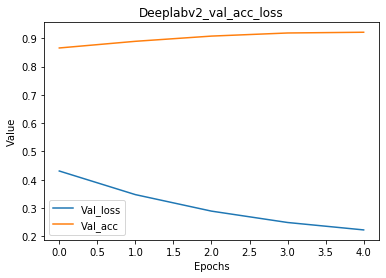

In [12]:
show_val_acc_loss(history.history)

In [0]:
def show_acc_loss(history):
    fig = plt.figure()
    plt.plot(history['loss'])
    plt.title("Deeplabv2_trian_acc_loss")
    plt.plot(history['accuracy'])
    plt.ylabel('Value')
    plt.xlabel('Epochs')
    plt.legend(['train_loss', 'trian_acc'], loc=0)
    fig.savefig("Deeplabv2_acc_loss.png")

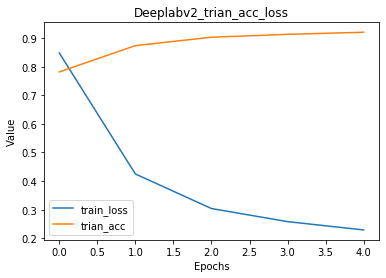

In [14]:
show_acc_loss(history.history)

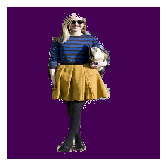

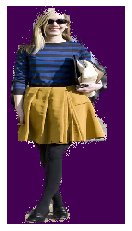

In [16]:
# test_test_data(30, '/content/drive/My Drive/project/deeplab_weights.h5')

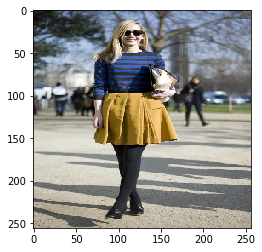

In [17]:
# plt.imshow(cv2.cvtColor(np.squeeze(img_test[30]/255), cv2.COLOR_BGR2RGB))